In [1]:
import os
import random
from shutil import copy2
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from PIL import Image
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc,roc_auc_score,precision_recall_curve
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage import feature, io, color
from skimage.feature import local_binary_pattern, hog
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU

#### DATA

Extracted the images from Celeb-v2 dataset using cv2 package. And then stored in the Hardisk.

In [2]:
real_images_base_dir = '/Volumes/Expansion/data/extracted_frames'
fake_images_base_dir = '/Volumes/Expansion/Fake_Extracted_Frames'

Images are stored in separate folders for real and fake images, the function get_image_path is used to create a list which consists of image paths.

In [3]:
def get_image_paths(base_dir):
    image_paths = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if not file.startswith('._') and file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [4]:
real_image_paths = get_image_paths(real_images_base_dir)
fake_image_paths = get_image_paths(fake_images_base_dir)

In [5]:
print(len(real_image_paths))
print(len(fake_image_paths))

10001
1136390


In [6]:
s = real_image_paths[3]

In [7]:
image = Image.open(s)
width, height = image.size
print("Width:", width)
print("Height:", height)

Width: 518
Height: 498


Extracted 10001 real images and 1126390 fake images from  590 real videos and  5639 fake videos respectively. since the dataset is imbalanced, the same number of random fake images are used.

In [8]:
def sample_images(image_paths, sample_size):
    random.seed(42)
    if len(image_paths) > sample_size:
        return random.sample(image_paths, sample_size)
    return image_paths

In [9]:
min_image_count = min(len(real_image_paths), len(fake_image_paths))
real_images_sample = sample_images(real_image_paths, min_image_count)
fake_images_sample = sample_images(fake_image_paths, min_image_count)

In [10]:
print(len(real_images_sample))
print(len(fake_images_sample))

10001
10001


After under sampling, we got an equal number of samples from both the real and fake classes, totalling 10001 real images and 10001 fake images. The size of all extracted image is 518x498.

#### DATA SPLIT INTO TRAIN and TEST

Split the data into training and testing sets with an 80:20 ratio.

In [11]:
# Split real images 
real_images_train, real_images_test = train_test_split(real_images_sample, test_size=0.2, random_state=42)

# Split fake images 
fake_images_train, fake_images_test = train_test_split(fake_images_sample, test_size=0.2, random_state=42)


In [12]:
print("Number of real images in training set ", len(real_images_train))
print("Number of real images in testing set ", len(real_images_test))
print("Number of fake images in training set ", len(fake_images_train))
print("Number of fake images in testing set ", len(fake_images_test))

Number of real images in training set  8000
Number of real images in testing set  2001
Number of fake images in training set  8000
Number of fake images in testing set  2001


After splitting, the training set contains 8,000 real images and 8000 fake images, while the testing set consists of 2001 real images and 2,001 fake images.

### MesoNet

Model architecture used from the github repository https://github.com/DariusAf/MesoNet/tree/master. I added 'base_model' and 'feature_model' in the Meso model. While base_model represents the full classification model, feature_model outputs features from the last convolutional layer (x4). 

In [13]:
IMGWIDTH = 256

class Classifier:
    def __init__(self):
        self.model = None
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y, batch_size=32, epochs=10):
        return self.model.fit(x, y, batch_size=batch_size, epochs=epochs)
    
    def get_accuracy(self, x, y):
        return self.model.evaluate(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.base_model, self.feature_model = self.init_model()
        optimizer = Adam(learning_rate=learning_rate)
        self.base_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
        self.model = self.base_model  
    
    def init_model(self):
        x = Input(shape=(IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        feature_output = x4
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)
        
        base_model = KerasModel(inputs=x, outputs=y)
        feature_model = KerasModel(inputs=x, outputs=feature_output)

        return base_model, feature_model



In [14]:
meso_model = Meso4()
# meso_model.load('Meso4_DF.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
print(meso_model.base_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,073 (109.66 KB)

 Trainable params: 27,977 (109.29 KB)

 Non-trainable params: 96 (384.00 B)

None


### Training MesoNet

To preprocess real and fake images for training the MesoNet model, the 'preprocess_images' function is utilized. This function first resizes the images to 256x256 dimensions, then converts them into arrays, and finally normalizes the pixel values to be between 0 and 1. All the processed images are added to a list and returned as a stack of preprocessed images. Subsequently, these processed 16000 train_images, along with their corresponding labels (0 for fake and 1 for real), are fed into the MesoNet network for training.

In [16]:
def preprocess_images(image_paths, target_size=(256, 256)):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        img /= 255.0 
        images.append(img)
    return np.stack(images)

In [17]:
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size) 
    img_array = img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0  
    return img_array

In [18]:
train_images = preprocess_images(real_images_train + fake_images_train)

In [19]:
train_images.shape

(16000, 256, 256, 3)

In [20]:
print(len(train_images))

16000


In [21]:
y_train = np.concatenate([np.ones(len(real_images_train)), np.zeros(len(fake_images_train))])

In [22]:
y_train.shape

(16000,)

For training purposes, the real samples are labeled as 1 and the fake samples are labeled as 0. 

In [23]:
test_images = preprocess_images(real_images_test + fake_images_test)

In [24]:
y_test = np.concatenate([np.ones(len(real_images_test)), np.zeros(len(fake_images_test))])

In [25]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, verbose=1)

MesoNet base model is trained on the training images (train_images) and their corresponding labels (y_train) for 20 epochs with a batch size of 32 with earlystopping

In [26]:
meso_model.base_model.fit(train_images, y_train, epochs=20, batch_size=32,callbacks=[early_stopping])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 305s 606ms/step - accuracy: 0.7698 - loss: 0.1670
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 596ms/step - accuracy: 0.9636 - loss: 0.0311
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 596ms/step - accuracy: 0.9745 - loss: 0.0226
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 303s 607ms/step - accuracy: 0.9811 - loss: 0.0182
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 297s 594ms/step - accuracy: 0.9799 - loss: 0.0189
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 595ms/step - accuracy: 0.9809 - loss: 0.0177
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 596ms/step - accuracy: 0.9731 - loss: 0.0242
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 296s 593ms/step - accuracy: 0.9771 - loss: 0.0207
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 596ms/step - accuracy: 0.9819 - loss: 0.0170
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 298s 596ms/step - accuracy: 0.9807 - loss: 0.0177
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 301s 601ms/step - accuracy: 0.9820 - loss: 0.0169
Epoch 12

In [27]:
meso_predictions = meso_model.model.predict(test_images)
meso_predicted_labels = (meso_predictions > 0.5).astype(int)  

126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step


In [28]:
print(classification_report(y_test, meso_predicted_labels))
print("Accuracy:", accuracy_score(y_test, meso_predicted_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      2001
         1.0       0.97      1.00      0.99      2001

    accuracy                           0.99      4002
   macro avg       0.99      0.99      0.99      4002
weighted avg       0.99      0.99      0.99      4002

Accuracy: 0.9855072463768116


In [29]:
def perfomance(y_pred):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC AUC: {roc_auc}")

In [30]:
perfomance(meso_predicted_labels)

Accuracy: 0.9855072463768116
Precision: 0.971830985915493
Recall: 1.0
F1 Score: 0.9857142857142858
ROC AUC: 0.9855072463768115


In [129]:
report = classification_report(y_test, meso_predicted_labels)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99      2001
         1.0       0.97      1.00      0.99      2001

    accuracy                           0.99      4002
   macro avg       0.99      0.99      0.99      4002
weighted avg       0.99      0.99      0.99      4002



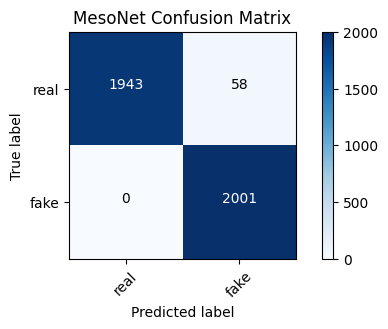

In [111]:
cm = confusion_matrix(y_test, meso_predicted_labels)
plt.figure(figsize=(5.5, 3.2))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MesoNet Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['real', 'fake'], rotation=45)
plt.yticks(tick_marks, ['real', 'fake'])
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### LBP

#### Feature Extraction using LBP

The 'compute_lbp_features' function calculates the Local Binary Pattern (LBP) for each image and generates a histogram with 1024 bins, resulting in 1024 features for each image. Before computing the LBP, the image undergoes preprocessing using the 'load_image' function, which converts it to grayscale, resizes it to 256x256, and converts it to an array.
Ref :
https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.local_binary_pattern.
https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In [32]:
def compute_lbp_features(images, radius=3, points=24, method='uniform'):
    """Compute LBP features for a list of images."""
    num_bins = points * (points - 1) + 3
    lbp_features = []
    for img_path in images:
        img = load_image(img_path)
        lbp = local_binary_pattern(img, P=points, R=radius, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=num_bins, range=(0, num_bins), density=True)
        lbp_features.append(hist)
    return lbp_features

In [33]:
def load_image(image_path, target_size=(256, 256)): 
    with Image.open(image_path) as img:
        img = img.convert('L')  
        img = img.resize(target_size) 
        return np.array(img)

In [34]:
real_train_lbp = compute_lbp_features(real_images_train)

In [35]:
print(len(real_train_lbp))

8000


In [36]:
fake_train_lbp = compute_lbp_features(fake_images_train)

In [37]:
print(len(fake_train_lbp))

8000


##### Feature Extraction using MesoNEt

In [38]:
def extract_features_with_mesonet(feature_extractor, image_paths):
    features = []
    for img_path in image_paths:
        if not os.path.basename(img_path).startswith('._'):  
            try:
                img_array = load_and_preprocess_image(img_path)
                image_features = feature_extractor.feature_model.predict(img_array)
                features.append(image_features.flatten())  
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue
    return np.stack(features) 

The 'extract_features_with_mesonet' function is used to extract features from each image using the MesoNet network. Before feeding the image into MesoNet, it undergoes preprocessing through the 'load_and_preprocess_image' function. This function loads the image, resizes it to the specified 256x256 size, converts it to an array, expands its dimensions, and normalizes the pixel values to between 0 and 1. Subsequently, the preprocessed image is input into MesoNet to extract features from its hidden layer. Finally, the extracted feature vector is flattened into a 1D array.

In [39]:
meso_trainfeatures = extract_features_with_mesonet(meso_model,real_images_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

Here we extracted 1024 features from Mesonetwork for each image in 8000 real sample 

In [ ]:
meso_fake_trainfeatures = extract_features_with_mesonet(meso_model,fake_images_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

Here we extracted 1024 features from Mesonetwork for each image in 8000 real sample 

In [ ]:
real_train = np.concatenate((real_train_lbp, meso_trainfeatures), axis=1)
fake_train = np.concatenate((fake_train_lbp, meso_fake_trainfeatures), axis=1)

Here, the features extracted from both the LBP and the MesoNet network are combined for both real and fake samples.

In [ ]:
X_train = np.vstack((real_train, fake_train))

This function combines the real and fake training images into a single array along their vertical axis. it consists of 16,000 samples with 2048 features each.

SVM classifier with a linear kernel used and trained the classifier on the training data (X_train and y_train) using the fit method.

## Testing data 

In [43]:
real_test_lbp = compute_lbp_features(real_images_test)

The 1024 features for real samples have been extracted.

In [44]:
len(real_test_lbp)

2001

In [45]:
fake_test_lbp = compute_lbp_features(fake_images_test)

The 1024 features for fake samples have been extracted.

In [46]:
len(fake_test_lbp)

2001

In [47]:
meso_real_testfeatures = extract_features_with_mesonet(meso_model,real_images_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [48]:
meso_real_testfeatures.shape

(2001, 1024)

Extracted 1024 features for each real image in total of 2001

In [49]:
meso_fake_testfeatures = extract_features_with_mesonet(meso_model,fake_images_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [50]:
meso_fake_testfeatures.shape

(2001, 1024)

Extracted 1024 features for each fake image in total of 2001

In [51]:
real_test = np.concatenate((real_test_lbp, meso_real_testfeatures), axis=1)

In [52]:
real_test.shape

(2001, 1579)

In [53]:
fake_test = np.concatenate((fake_test_lbp, meso_fake_testfeatures), axis=1)

Here, the features extracted from both the LBP and the MesoNet network are combined for both real and fake testing samples.

In [54]:
real_test.shape

(2001, 1579)

In [55]:
X_test = np.vstack((real_test, fake_test))

This function combines the real and fake testing images into a single array along their vertical axis. it consists of 2001 samples with 2048 features each.

In [56]:
# y_test = np.concatenate([np.ones(len(real_test)), np.zeros(len(fake_test))])

the real samples are labeled as 1, and the fake samples are labeled as 0. 

#### SVM Training and Testing

In [166]:
scaler_combined = StandardScaler()
scaler_combined.fit(X_train)
X_train_combined = scaler_combined.transform(X_train)
X_test_combined = scaler_combined.transform(X_test)

Here the combined features are scaled using standardScalar function, scaler object 'scaler_combined' fitted only the train data and then used this trained object to scale the train and test data, (where mean and standard deviation estimated from train data is being used)

In [167]:
def SVM(kernel, X_train, X_test, y_train, y_test):
    clf = svm.SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5.5, 3.2))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{kernel} kernel Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['real', 'fake'], rotation=45)
    plt.yticks(tick_marks, ['real', 'fake'])
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

This function 'SVM' train SVM model  with specified kernel on training data. And then predicts and evaluated the perfomance on test data. This function also print all perfomance meterics like accuracy, precision, recall, F1 score and plot the confusion matrix.

### SVM with combined features

The following code demonstrates the performance of an SVM using combined features with different kernels:

Accuracy: 0.9900049975012494
Precision: 0.9861179970252851
Recall: 0.9940029985007496
F1 Score: 0.9900447984071677
ROC AUC: 0.9900049975012495


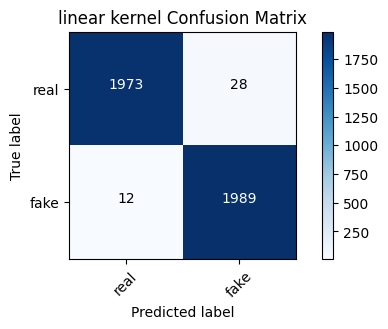

In [168]:
SVM('linear', X_train_combined, X_test_combined, y_train, y_test)

##### SVM With different Kernels

Accuracy: 0.9892553723138431
Precision: 0.9794319294809011
Recall: 0.9995002498750625
F1 Score: 0.9893643334157803
ROC AUC: 0.9892553723138432


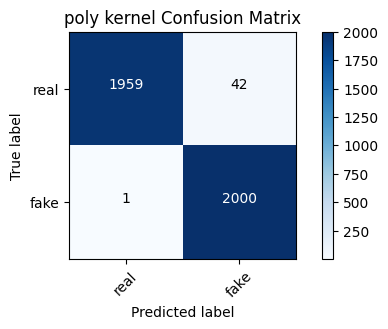

In [169]:
SVM('poly', X_train_combined, X_test_combined, y_train, y_test)

Accuracy: 0.9865067466266867
Precision: 0.9737226277372263
Recall: 1.0
F1 Score: 0.9866863905325444
ROC AUC: 0.9865067466266866


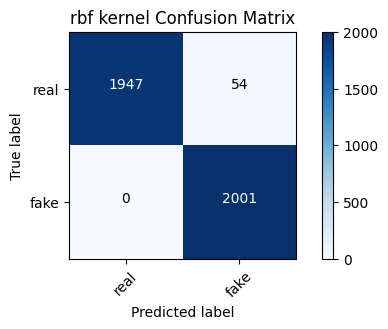

In [170]:
SVM('rbf', X_train_combined, X_test_combined, y_train, y_test)

Accuracy: 0.9780109945027486
Precision: 0.9668130795510005
Recall: 0.9900049975012494
F1 Score: 0.9782716049382716
ROC AUC: 0.9780109945027486


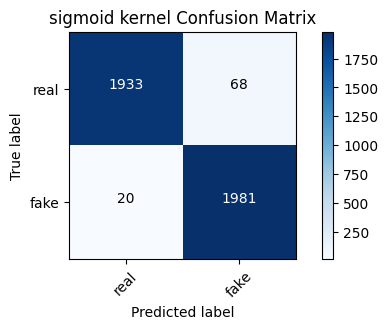

In [171]:
SVM('sigmoid', X_train_combined, X_test_combined, y_train, y_test)

#### LBP only

In [117]:
X_train_lbp_only = np.vstack([real_train_lbp, fake_train_lbp])
X_test_lbp_only = np.vstack([real_test_lbp, fake_test_lbp])

Here LBP features are scaled using 'scaler_lbp' object

In [172]:
scaler_lbp = StandardScaler()
scaler_lbp.fit(X_train_lbp_only)
X_train_lbp = scaler_lbp.transform(X_train_lbp_only)
X_test_lbp = scaler_lbp.transform(X_test_lbp_only)

The following code demonstrates the performance of an SVM using LBP features with different kernels:

Accuracy: 0.6819090454772614
Precision: 0.6659070191431176
Recall: 0.7301349325337332
F1 Score: 0.6965435041716329
ROC AUC: 0.6819090454772614


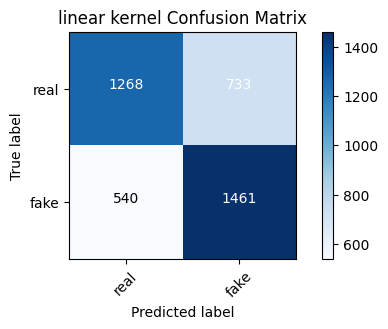

In [173]:
SVM('linear', X_train_lbp, X_test_lbp, y_train, y_test)

Accuracy: 0.9235382308845578
Precision: 0.9269521410579346
Recall: 0.9195402298850575
F1 Score: 0.9232313095835424
ROC AUC: 0.9235382308845578


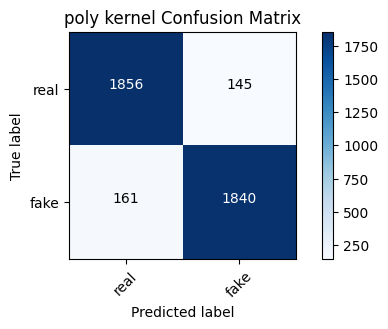

In [174]:
SVM('poly', X_train_lbp, X_test_lbp, y_train, y_test)

Accuracy: 0.975512243878061
Precision: 0.9563549160671463
Recall: 0.9965017491254373
F1 Score: 0.9760156632403328
ROC AUC: 0.975512243878061


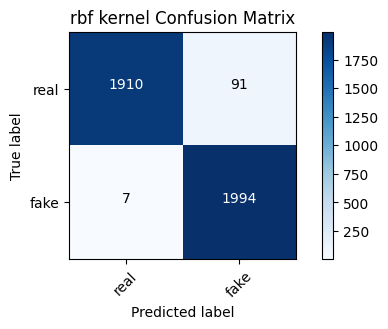

In [175]:
SVM('rbf', X_train_lbp, X_test_lbp, y_train, y_test)

Accuracy: 0.5564717641179411
Precision: 0.557070707070707
Recall: 0.551224387806097
F1 Score: 0.5541321276061291
ROC AUC: 0.5564717641179411


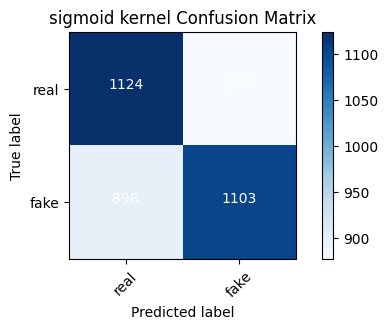

In [176]:
SVM('sigmoid', X_train_lbp, X_test_lbp, y_train, y_test)

#### Mesonet only

In [160]:
scaler_meso = StandardScaler()
X_train_meso_only = np.vstack([meso_trainfeatures, meso_fake_trainfeatures])
X_test_meso_only = np.vstack([meso_real_testfeatures, meso_fake_testfeatures])

In [177]:
scaler_meso.fit(X_train_meso_only)
X_train_meso = scaler_meso.fit_transform(X_train_meso_only)
X_test_meso = scaler_meso.transform(X_test_meso_only)

Accuracy: 0.9880059970014993
Precision: 0.9855793137742417
Recall: 0.9905047476261869
F1 Score: 0.9880358923230309
ROC AUC: 0.9880059970014993


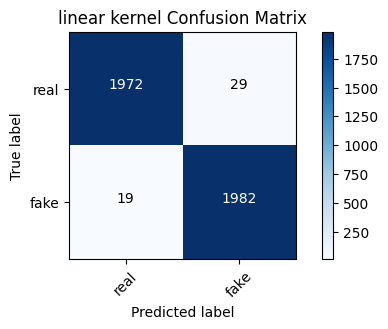

In [178]:
SVM('linear', X_train_meso, X_test_meso, y_train, y_test)

Accuracy: 0.9890054972513743
Precision: 0.9789525208027411
Recall: 0.9995002498750625
F1 Score: 0.9891196834817013
ROC AUC: 0.9890054972513743


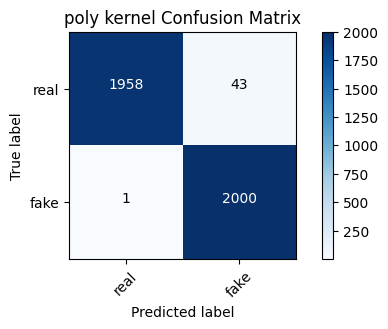

In [179]:
SVM('poly', X_train_meso, X_test_meso, y_train, y_test)

Accuracy: 0.9865067466266867
Precision: 0.9737226277372263
Recall: 1.0
F1 Score: 0.9866863905325444
ROC AUC: 0.9865067466266866


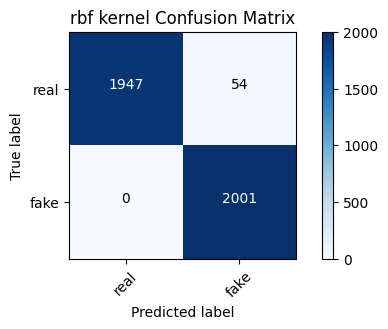

In [180]:
SVM('rbf', X_train_meso, X_test_meso, y_train, y_test)

Accuracy: 0.9747626186906547
Precision: 0.9616132167152576
Recall: 0.9890054972513743
F1 Score: 0.9751170238975116
ROC AUC: 0.9747626186906547


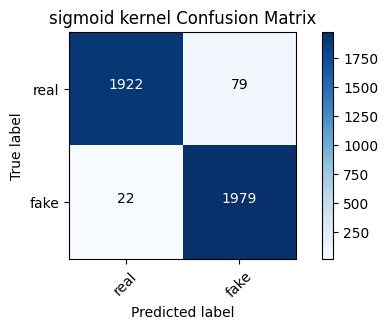

In [181]:
SVM('sigmoid', X_train_meso, X_test_meso, y_train, y_test)